In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load Dataset
df = pd.read_csv("exchange_rate.csv", parse_dates=[0], index_col=0)
df.sort_index(inplace=True)

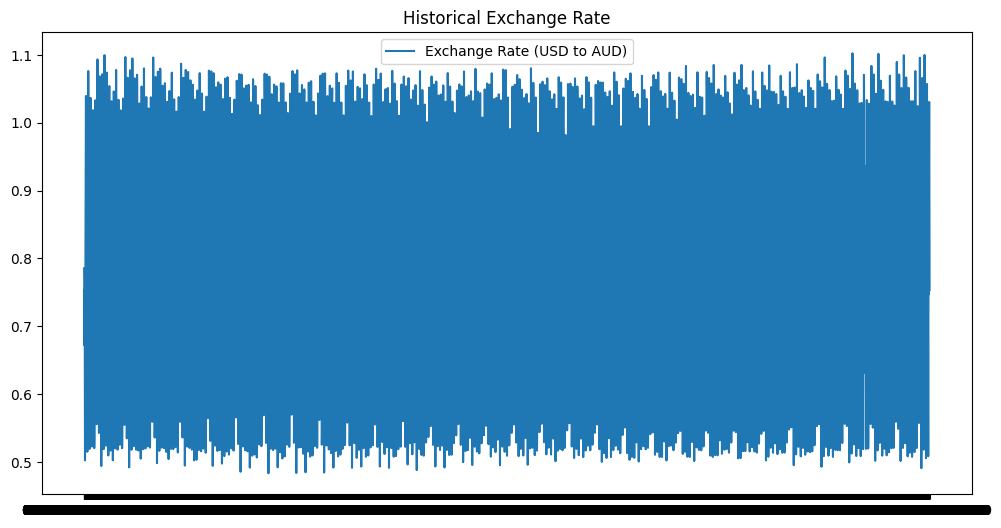

In [3]:
# Initial Exploration
plt.figure(figsize=(12, 6))
plt.plot(df, label='Exchange Rate (USD to AUD)')
plt.title('Historical Exchange Rate')
plt.legend()
plt.show()

In [4]:
# Check for missing values
df = df.ffill().bfill()

In [5]:
# Check stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

test_stationarity(df.iloc[:, 0])



ADF Statistic: -14.438089479961612
p-value: 7.437614382254163e-27
Critical Values:
   1%: -3.43121631233081
   5%: -2.8619228448447456
   10%: -2.566973783870177


In [6]:
# Differencing to make data stationary
df_diff = df.diff().dropna()
test_stationarity(df_diff.iloc[:, 0])


ADF Statistic: -28.6148661635049
p-value: 0.0
Critical Values:
   1%: -3.431216197578816
   5%: -2.861922794140392
   10%: -2.5669737568795616


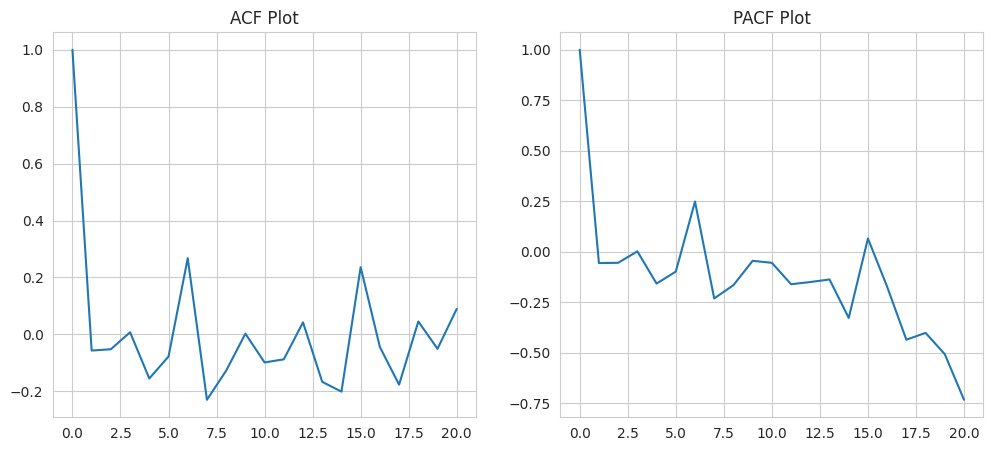

In [7]:

# Plot ACF & PACF for ARIMA parameter selection
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')
plt.subplot(121)
sns.lineplot(x=range(len(acf(df_diff.iloc[:, 0], nlags=20))), y=acf(df_diff.iloc[:, 0], nlags=20))
plt.title("ACF Plot")
plt.subplot(122)
sns.lineplot(x=range(len(pacf(df_diff.iloc[:, 0], nlags=20))), y=pacf(df_diff.iloc[:, 0], nlags=20))
plt.title("PACF Plot")
plt.show()


In [8]:
# Fit ARIMA Model
p, d, q = 1, 1, 1  # Based on ACF/PACF analysis
model_arima = ARIMA(df, order=(p, d, q))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7260.780
Date:                Sat, 04 Jan 2025   AIC                         -14515.560
Time:                        13:29:15   BIC                         -14494.758
Sample:                             0   HQIC                        -14508.421
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7336      0.009     79.748      0.000       0.716       0.752
ma.L1         -1.0000      0.329     -3.042      0.002      -1.644      -0.356
sigma2         0.0086      0.003      3.036      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


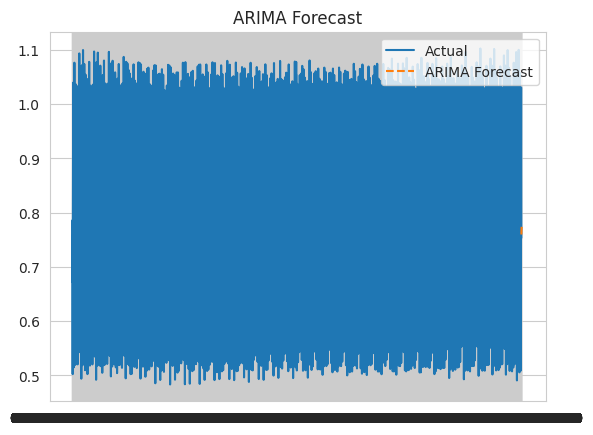

In [9]:
# Forecast with ARIMA
forecast_arima = model_arima_fit.forecast(steps=30)
plt.plot(df, label='Actual')
plt.plot(forecast_arima, label='ARIMA Forecast', linestyle='dashed')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


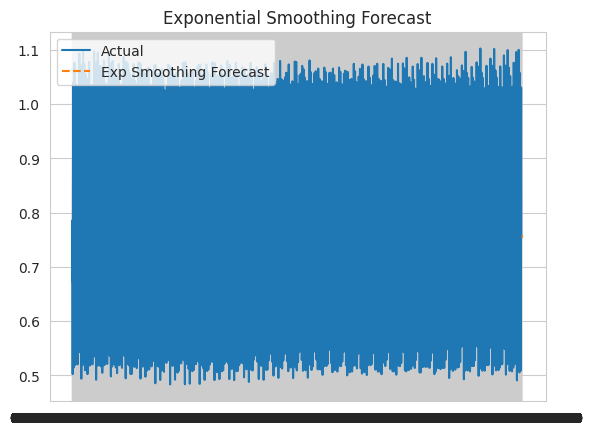

In [10]:
# Fit Exponential Smoothing Model
model_es = ExponentialSmoothing(df, trend='add', seasonal=None).fit()
forecast_es = model_es.forecast(steps=30)

# Plot Exponential Smoothing Forecast
plt.plot(df, label='Actual')
plt.plot(forecast_es, label='Exp Smoothing Forecast', linestyle='dashed')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()

In [11]:
# Evaluate Models
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

evaluate_model(df[-30:], forecast_arima)
evaluate_model(df[-30:], forecast_es)

# Conclusion
print("Comparison Complete: Check MAE and RMSE to choose the best model.")


MAE: 0.1140812098603733
RMSE: 0.14529695242629798
MAE: 0.11575056456568623
RMSE: 0.15089953281581567
Comparison Complete: Check MAE and RMSE to choose the best model.
